# Basic stuff

In [43]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [44]:
data = pd.read_csv("https://raw.githubusercontent.com/Makxxx/data_dmmlProject/main/training_data.csv", index_col=0, dtype=str)
data.sentence = data.sentence.apply(lambda s: s.replace("'", ' '))
labels = data.difficulty.unique()
num_labels = len(labels)
data.difficulty = LabelEncoder().fit_transform(data.difficulty)

In [45]:
data

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,4
1,"Le bleu, c est ma couleur préférée mais je n a...",0
2,Le test de niveau en français est sur le site ...,0
3,Est-ce que ton mari est aussi de Boston?,0
4,"Dans les écoles de commerce, dans les couloirs...",2
...,...,...
4795,"C est pourquoi, il décida de remplacer les hab...",3
4796,Il avait une de ces pâleurs splendides qui don...,4
4797,"Et le premier samedi de chaque mois, venez ren...",1


In [46]:
X_train, X_test, y_train, y_test = train_test_split(data.sentence, data.difficulty, test_size=0.2)

In [47]:
from nltk.corpus import stopwords
# Pipeline : suite d'opération 
def create_and_train_pipeline(classifier, X_train, y_train):
    pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', classifier()),
        ])

    pipe.fit(X_train, y_train)
    return pipe

lr_clf = create_and_train_pipeline(LogisticRegression, X_train, y_train)
knn_clf = create_and_train_pipeline(KNeighborsClassifier, X_train, y_train)
dt_clf = create_and_train_pipeline(DecisionTreeClassifier, X_train, y_train)
rf_clf = create_and_train_pipeline(RandomForestClassifier, X_train, y_train)
xgb_clf = create_and_train_pipeline(XGBClassifier, X_train, y_train)

In [48]:
# pipe = Pipeline([
#             ('vect', CountVectorizer()),
#             ('tfidf', TfidfTransformer()),
#             ('clf', LogisticRegression()),
#         ])
# pipe.fit(X_train, y_train)

# pipe = Pipeline([
#             ('vect', CountVectorizer()),
#             ('tfidf', TfidfTransformer()),
#             ('clf', KNeighborsClassifier()),
#         ])
# pipe.fit(X_train, y_train)
# ...

In [49]:
def evaluate_clf(clf, X_test, y_test, full=False):
    predicted = clf.predict(X_test)
    if full:
        return classification_report(y_test, predicted, target_names=labels)
    else:
        return np.mean(y_test == predicted)

In [50]:
print("logistic", evaluate_clf(lr_clf, X_test, y_test))
print("knn", evaluate_clf(knn_clf, X_test, y_test))
print("dt", evaluate_clf(dt_clf, X_test, y_test))
print("rf", evaluate_clf(rf_clf, X_test, y_test))
print("xgb", evaluate_clf(xgb_clf, X_test, y_test))

logistic 0.459375
knn 0.29375
dt 0.340625
rf 0.4166666666666667
xgb 0.390625


In [51]:
#from google.colab import drive
#drive.mount('/content/drive')

In [52]:
#train_df = pd.read_csv('/content/drive/MyDrive/training_data.csv')
#train_df.shape

In [53]:
print(evaluate_clf(lr_clf, X_test, y_test, full=True))

              precision    recall  f1-score   support

          C1       0.49      0.64      0.56       146
          A1       0.37      0.30      0.33       155
          B1       0.39      0.35      0.37       156
          A2       0.46      0.38      0.41       164
          B2       0.50      0.44      0.47       176
          C2       0.49      0.65      0.56       163

    accuracy                           0.46       960
   macro avg       0.45      0.46      0.45       960
weighted avg       0.45      0.46      0.45       960



In [54]:
print(evaluate_clf(knn_clf, X_test, y_test, full=True))

              precision    recall  f1-score   support

          C1       0.25      0.82      0.38       146
          A1       0.19      0.21      0.20       155
          B1       0.20      0.13      0.16       156
          A2       0.44      0.16      0.24       164
          B2       0.58      0.19      0.29       176
          C2       0.57      0.29      0.39       163

    accuracy                           0.29       960
   macro avg       0.37      0.30      0.28       960
weighted avg       0.38      0.29      0.28       960



# Real stuff

In [55]:
!pip install transformers datasets pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
from pprint import pprint
import functools

import torch #GPU optim. + gradient opt.
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [57]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')
#clean, tokenize as proprecessing is required for model camambert

In [58]:
dataset = load_dataset('Makxxx/french_CEFR') # stocked in huggingface, like a github for dataset. --> cambembert already loaded with right functions
dataset


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 4320
    })
    test: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 1200
    })
    validation: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 480
    })
})

In [59]:
pd_dataset = {split_name: split_data.to_pandas() for split_name, split_data in dataset.items()}
pd_dataset["validation"] #to test why we choose validation

,sentence,difficulty,label
0,Je vais trouver une autre solution à ce problème.,A2,1
1,Je suis chez Camille,A1,0
2,Je me sens bien.,A1,0
3,"mon ami, j'ai peur de la méchante femme.",A2,1
4,"""avoir compassion de"" signifie ""avoir de la pi...",A2,1
...,...,...,...
475,"C'est pourquoi, il décida de remplacer les hab...",B2,3
476,Il avait une de ces pâleurs splendides qui don...,C1,4
477,"Et le premier samedi de chaque mois, venez ren...",A2,1
478,Les coûts liés à la journalisation n'étant pas...,C2,5


Le dataset comprend 6 labels.


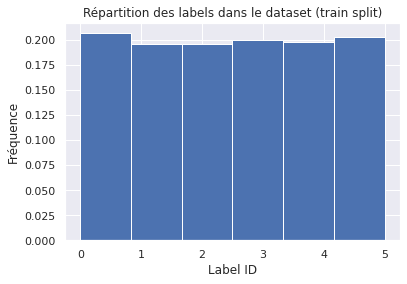

In [60]:
sns.set_theme()

nb_labels = len(pd_dataset["train"]["label"].unique())
print(f"Le dataset comprend {nb_labels} labels.")

ax = pd_dataset["train"]["label"].hist(density=True, bins=nb_labels)
ax.set_xlabel("Label ID")
ax.set_ylabel("Fréquence")
ax.set_title("Répartition des labels dans le dataset (train split)")
ax.figure.show()

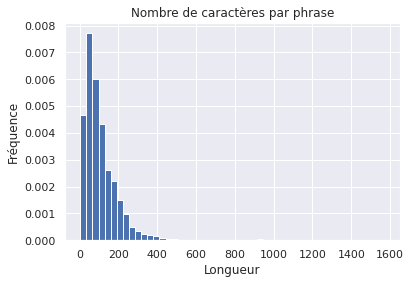

In [61]:
pd_dataset["train"]["len_sen"] = pd_dataset["train"]["sentence"].apply(lambda x: len(x))
ax = pd_dataset["train"]["len_sen"].hist(density=True, bins=50)
ax.set_xlabel("Longueur")
ax.set_ylabel("Fréquence")
ax.set_title("Nombre de caractères par phrase")
ax.figure.show()

In [62]:
pd_dataset["train"]["len_sen"].max()

1572

In [63]:
# batch : train batch easier on the processor.

from sklearn.preprocessing import LabelEncoder

def tokenize_batch(samples, tokenizer):
    text = [sample["sentence"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    str_labels = [sample["difficulty"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [64]:
train_dataset, test_dataset, val_dataset = dataset.values()

In [65]:
num_labels = len(pd_dataset["train"]["label"].unique())

Il est important, surtout avec de petits jeux de données, que le modèle ne voit pas les données dans le même ordre. Pour éviter cela, on utilise l'argument `shuffle` du DataLoader.

In [66]:
#faire le lien entre dataset et les diff modèles. On met en place les paramètre batch et random.
train_dataloader = DataLoader(
    dataset["train"], 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
val_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

In [67]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [68]:
lightning_model = LightningModel("camembert-base", num_labels, lr=3e-5, weight_decay=2)
# creation du modele au dessus
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20, #how many times iteration on dataset
    gpus=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

In [ ]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.506   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path) #5
#recover best model we found.

In [ ]:
ID_TO_LABEL = dict(zip(range(6), ('A1', 'A2', 'B1', 'B2', 'C1', 'C2',)))
label_names = list(ID_TO_LABEL.values())

In [ ]:
def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )

In [ ]:
camembert_preds = camembert_trainer.predict(lightning_model, dataloaders=val_dataloader)
camembert_preds = torch.cat(camembert_preds, -1)

In [ ]:
plot_confusion_matrix(dataset["validation"]["label"], camembert_preds, label_names)

In [ ]:
print(classification_report(dataset["validation"]["label"], camembert_preds, target_names=label_names))

In [ ]:
wrong_preds = camembert_preds.numpy() != np.array(dataset["validation"]["label"])
wrong = dataset["validation"].to_pandas()[['sentence', 'difficulty']][wrong_preds]

In [ ]:
preds = pd.Series(camembert_preds.numpy())[wrong_preds].apply(lambda x: ID_TO_LABEL[x])
wrong["preds"] = preds
wrong.columns = ["sentence", "true", "predicted"]
wrong

In [ ]:
test_dataloader = DataLoader(
    dataset["test"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

preds = camembert_trainer.predict(lightning_model, dataloaders=test_dataloader)
preds = torch.cat(preds, -1) # ?

test_df = dataset["test"].to_pandas()
test_df_metrics = dataset["test"].to_pandas()
test_df.label = preds.numpy()
test_df.difficulty = test_df.label.apply(lambda x: label_names[x])
test_df.index.name = 'id'
test_df.drop(columns=["sentence", "label"], inplace=True)

In [ ]:
test_df

In [ ]:
test_df.to_csv('preds.csv')

